# **1) Deduping**

In [1]:
# Install gspread and authentication libraries
!pip install --upgrade gspread google-auth-oauthlib google-auth-httplib2

In [2]:
import torch

print("CUDA available?", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("Device count:", torch.cuda.device_count())
    print("Current device index:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(0))

CUDA available? True
CUDA version: 12.4
Device count: 1
Current device index: 0
Device name: Tesla T4


In [3]:
from google.colab import auth
from google.auth import default
import gspread
import pandas as pd

# Authenticate and initialize gspread client
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Open the Google Sheet using the sheet ID (this is from your link)
sheet_id = "1ynXr2X-uyTEGlbhKHcq6rxJ0y8y25aORnBcDoj-_4HY"
worksheet = gc.open_by_key(sheet_id).sheet1  # Open the first sheet

# Get all data in the sheet as a list of dictionaries
data = worksheet.get_all_records()

# Convert to DataFrame
df = pd.DataFrame(data)

# Print the shape before deduplication
print(f"Before deduplication: {df.shape[0]} rows, {df.shape[1]} columns")

# Remove duplicates
df_dedup = df.drop_duplicates()

# Print the shape after deduplication
print(f"After deduplication: {df_dedup.shape[0]} rows, {df_dedup.shape[1]} columns")

# Save the deduplicated DataFrame as a new CSV file on Google Drive
df_dedup.to_csv('/content/drive/MyDrive/HMS_Brain_Activity/eeg_spect_full_features_dedup.csv', index=False)

Before deduplication: 106800 rows, 54 columns
After deduplication: 106800 rows, 54 columns


# **2) Band‑pass & notch filtering on raw EEG**

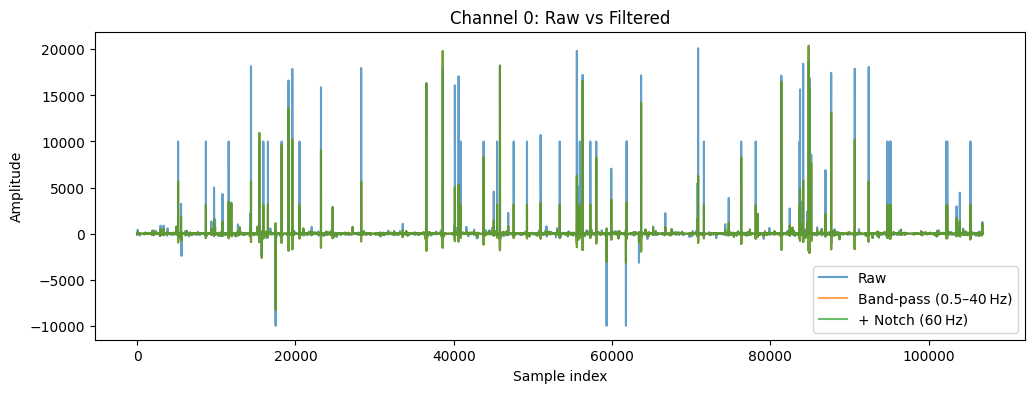

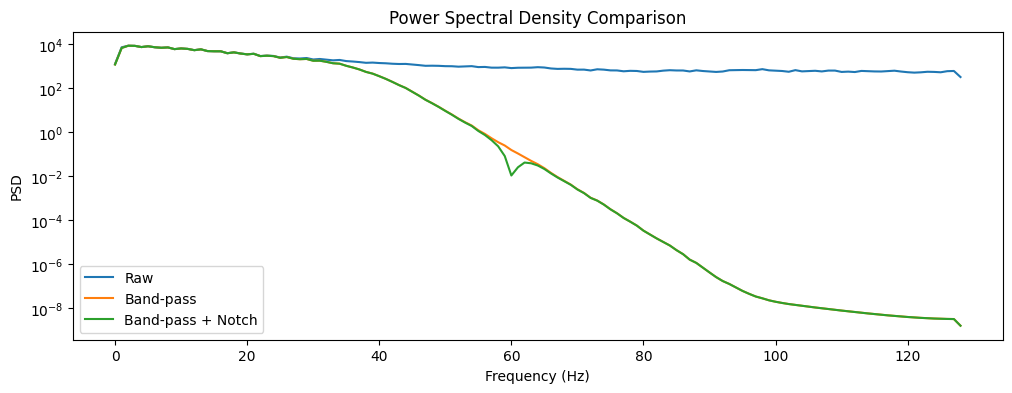

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch

# ====== 2.1 Define your filters ======
def bandpass(x, low=0.5, high=40, fs=256, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, x)

def notch(x, freq=60.0, fs=256, Q=30):
    nyq = 0.5 * fs
    w0 = freq / nyq
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, x)

# ====== 2.2 Load your EEG data ======
# If the data is in a pandas DataFrame 'df', you can extract the EEG channels.
# Let's assume 'df' contains columns for EEG data with channels like 'Fp1', 'O1', etc.
# Convert to numpy array (each column is a channel)
sig = df[['Fp1_median', 'O1_median', 'O2_median', 'Fp2_median']].values  # Example columns

# ====== 2.3 Pick a channel to visualize ======
channel_idx = 0
sig_ch = sig[:, channel_idx]  # Picking the first channel (adjust based on your data)

# ====== 2.4 Apply filters ======
fs = 256  # sampling rate in Hz
bp_ch = bandpass(sig_ch, low=0.5, high=40, fs=fs)
bn_ch = notch(bp_ch, freq=60.0, fs=fs, Q=30)

# ====== 2.5 Visualize time-domain effect ======
plt.figure(figsize=(12, 4))
plt.plot(sig_ch, alpha=0.7, label='Raw')
plt.plot(bp_ch, alpha=0.7, label='Band‑pass (0.5–40 Hz)')
plt.plot(bn_ch, alpha=0.7, label='+ Notch (60 Hz)')
plt.title(f"Channel {channel_idx}: Raw vs Filtered")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

# ====== 2.6 Compare Power Spectral Density (PSD) ======
f_raw, P_raw = welch(sig_ch, fs=fs)
f_bp,  P_bp  = welch(bp_ch, fs=fs)
f_bn,  P_bn  = welch(bn_ch, fs=fs)

plt.figure(figsize=(12, 4))
plt.semilogy(f_raw, P_raw, label='Raw')
plt.semilogy(f_bp,  P_bp,  label='Band‑pass')
plt.semilogy(f_bn,  P_bn,  label='Band‑pass + Notch')
plt.title("Power Spectral Density Comparison")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.legend()
plt.show()

Band-pass filter (0.5–40 Hz): This filter keeps the brainwave frequencies typically associated with EEG (like delta, theta, alpha, and beta waves) while removing both low-frequency drifts and high-frequency noise.

Notch filter (60 Hz): This filter specifically targets and removes electrical interference, often caused by the power supply (e.g., mains electricity noise), which typically appears at 60 Hz.

The time-domain signal visualization shows the raw signal and its filtered versions (band-pass + notch) for one channel. After filtering, we see a much cleaner signal with reduced noise and distortion.

# **3. 1D Temporal Convolution**

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your filtered data is in 'df' and 'expert_consensus' is your target label
# Step 1: Prepare features and target variable
# Include all the relevant EEG features
X = df[['Fp1_median', 'Fp1_std', 'Fp1_min', 'Fp1_max',
        'O1_median', 'O1_std', 'O1_min', 'O1_max',
        'O2_median', 'O2_std', 'O2_min', 'O2_max',
        'Fp2_median', 'Fp2_std', 'Fp2_min', 'Fp2_max']].values
y = df['expert_consensus'].values

# Step 2: Normalize features (optional but generally helpful for deep learning models)
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Step 3: Encode target labels (if they're categorical)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Step 4: Reshape data for 1D convolution (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [6]:
# Step 6: Build the 1D Convolutional Neural Network Model
model = Sequential()

# Add 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))

# Add more convolutional layers (optional)
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten the output of the convolutional layers to feed into fully connected layers
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))  # Output layer with softmax

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 7: Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Step 8: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.2642 - loss: 1.7190 - val_accuracy: 0.3514 - val_loss: 1.5952
Epoch 2/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.3738 - loss: 1.5452 - val_accuracy: 0.3984 - val_loss: 1.5142
Epoch 3/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.4180 - loss: 1.4617 - val_accuracy: 0.4522 - val_loss: 1.4142
Epoch 4/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.4533 - loss: 1.3914 - val_accuracy: 0.4712 - val_loss: 1.3511
Epoch 5/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.4847 - loss: 1.3317 - val_accuracy: 0.4955 - val_loss: 1.2978
Epoch 6/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5087 - loss: 1.2838 - val_accuracy: 0.5290 - val_loss: 1.2542
Epoch 7/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5310 - loss: 1.2341 - val_accuracy: 0.5398 - val_loss: 1.2184
Epoch 8/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5430 - loss: 1.204

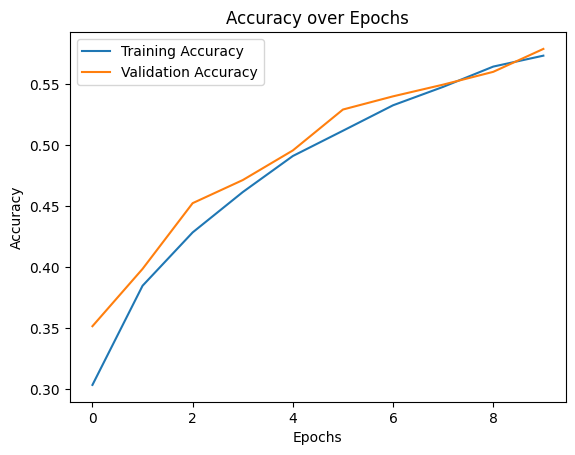

In [7]:
# Step 9: Plot Accuracy and Loss over Epochs
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

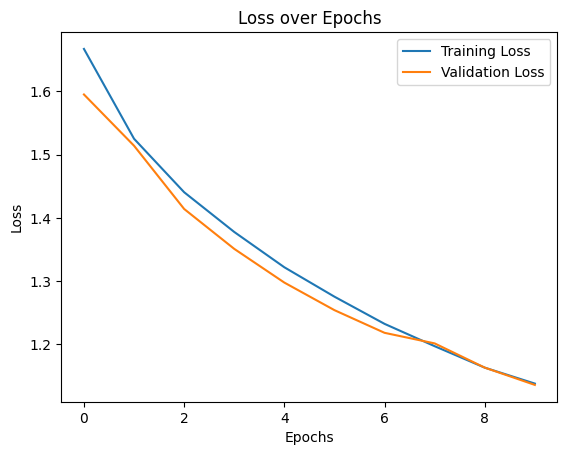

In [8]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(X_test)

class_names = le.classes_

# Generate classification report (with actual labels instead of index numbers)
y_pred_classes = np.argmax(y_pred, axis=1)  # y_pred is the predicted labels
print(classification_report(y_test, y_pred_classes, target_names=class_names))

668/668 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
              precision    recall  f1-score   support

         GPD       0.67      0.67      0.67      3444
        GRDA       0.53      0.67      0.59      3709
         LPD       0.49      0.50      0.49      2910
        LRDA       0.62      0.64      0.63      3375
       Other       0.48      0.41      0.44      3757
     Seizure       0.67      0.58      0.62      4165

    accuracy                           0.58     21360
   macro avg       0.58      0.58      0.58     21360
weighted avg       0.58      0.58      0.58     21360



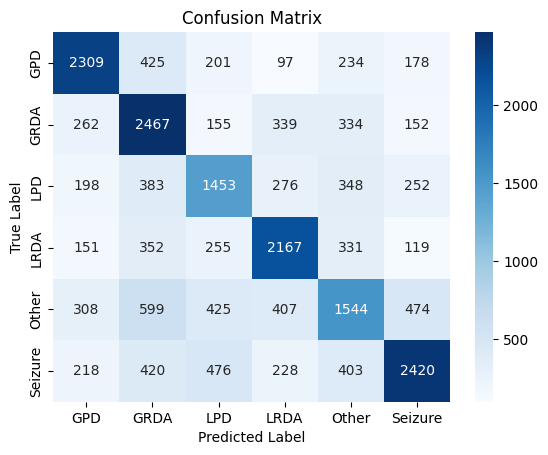

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 14, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,868 (276.83 KB)

 Trainable params: 23,622 (92.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,246 (184.56 KB)

In [13]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Step 6: Build the 1D Convolutional Neural Network Model with Padding
model = Sequential()

# Add 1D convolutional layer with ReLU activation and padding to prevent shrinking
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(X_train.shape[1], 1)))

# Add second convolutional layer with ReLU activation and padding
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))

# Add third convolutional layer with ReLU activation and padding
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))

# Add fourth convolutional layer with ReLU activation and padding
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

# Add fifth convolutional layer with ReLU activation and padding
model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

# Flatten the output of the convolutional layers to feed into fully connected layers
model.add(Flatten())

# Fully connected layer with ReLU activation
model.add(Dense(128, activation='relu'))

# Output layer with softmax activation
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))  # Change this to entmax if needed

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 7: Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Step 8: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2670/2670 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.2903 - loss: 1.6568 - val_accuracy: 0.5087 - val_loss: 1.2761
Epoch 2/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.5587 - loss: 1.1595 - val_accuracy: 0.6605 - val_loss: 0.9422
Epoch 3/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.6888 - loss: 0.8549 - val_accuracy: 0.7281 - val_loss: 0.7527
Epoch 4/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.7530 - loss: 0.6895 - val_accuracy: 0.7688 - val_loss: 0.6504
Epoch 5/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7980 - loss: 0.5717 - val_accuracy: 0.8025 - val_loss: 0.5847
Epoch 6/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8251 - loss: 0.4963 - val_accuracy: 0.8213 - val_loss: 0.5268
Epoch 7/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8483 - loss: 0.4347 - val_accuracy: 0.8378 - val_loss: 0.4830
Epoch 8/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8615 - loss: 0.3937 - val

In [14]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 16, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 16, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 16, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 16, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 8, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 8, 512)         │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 4, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,359,124 (9.00 MB)

 Trainable params: 786,374 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,572,750 (6.00 MB)

In [15]:
# Step 9: Generate classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Replace numerical labels with class names (using the provided labels)
class_names = ['GPD', 'GRDA', 'LPD', 'LRDA', 'Other', 'Seizure']

# Generate classification report
report = classification_report(y_test, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)

668/668 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Classification Report:
               precision    recall  f1-score   support

         GPD       0.93      0.89      0.91      3444
        GRDA       0.91      0.89      0.90      3709
         LPD       0.80      0.84      0.82      2910
        LRDA       0.86      0.94      0.90      3375
       Other       0.78      0.77      0.77      3757
     Seizure       0.89      0.85      0.87      4165

    accuracy                           0.86     21360
   macro avg       0.86      0.86      0.86     21360
weighted avg       0.86      0.86      0.86     21360



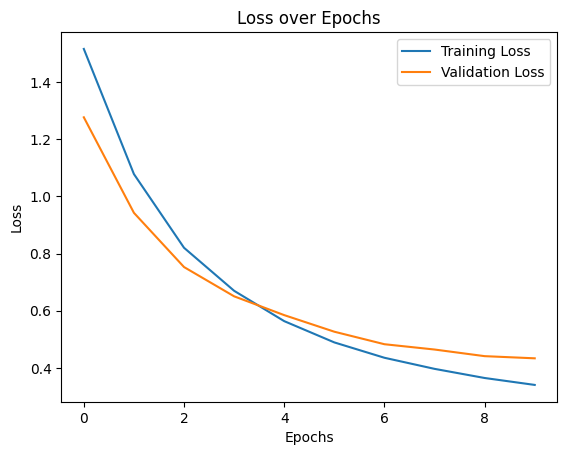

In [16]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

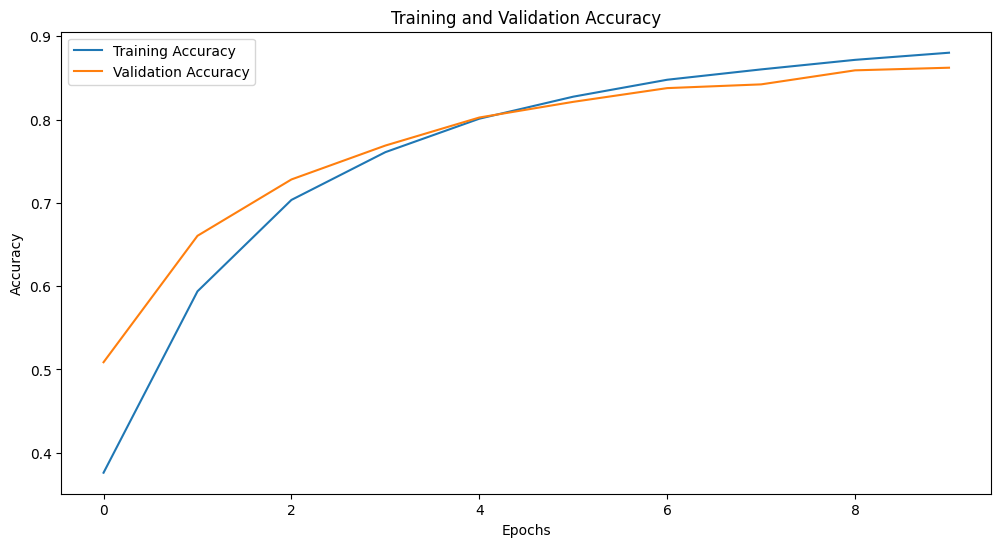

In [17]:
# Step 11: Plot Training/Validation Accuracy and Loss
# Accuracy plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

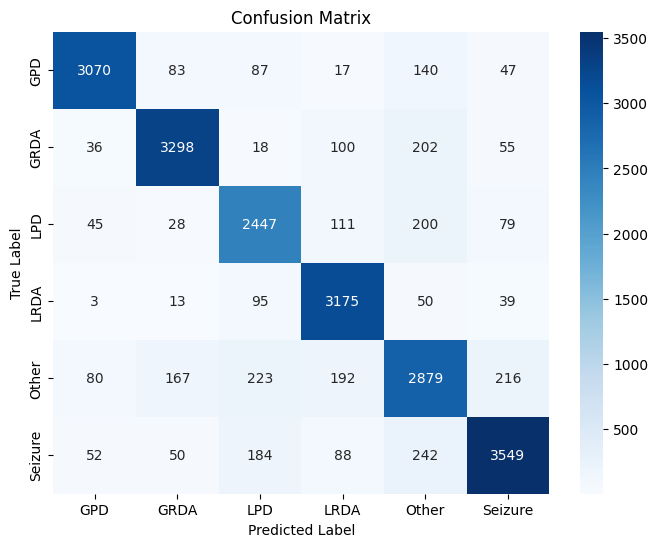

In [18]:
# Step 10: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2670/2670 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.2430 - loss: 1.7284 - val_accuracy: 0.3779 - val_loss: 1.4760 - learning_rate: 0.0010
Epoch 2/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.4161 - loss: 1.4600 - val_accuracy: 0.5229 - val_loss: 1.2467 - learning_rate: 0.0010
Epoch 3/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5026 - loss: 1.2769 - val_accuracy: 0.5764 - val_loss: 1.1086 - learning_rate: 0.0010
Epoch 4/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.5544 - loss: 1.1629 - val_accuracy: 0.6313 - val_loss: 0.9886 - learning_rate: 0.0010
Epoch 5/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.5940 - loss: 1.0656 - val_accuracy: 0.6602 - val_loss: 0.9033 - learning_rate: 0.0010
Epoch 6/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.6237 - loss: 0.9936 - val_accuracy: 0.6829 - val_loss: 0.8661 - learning_rate: 0.0010
Epoch 7/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6494 - loss:

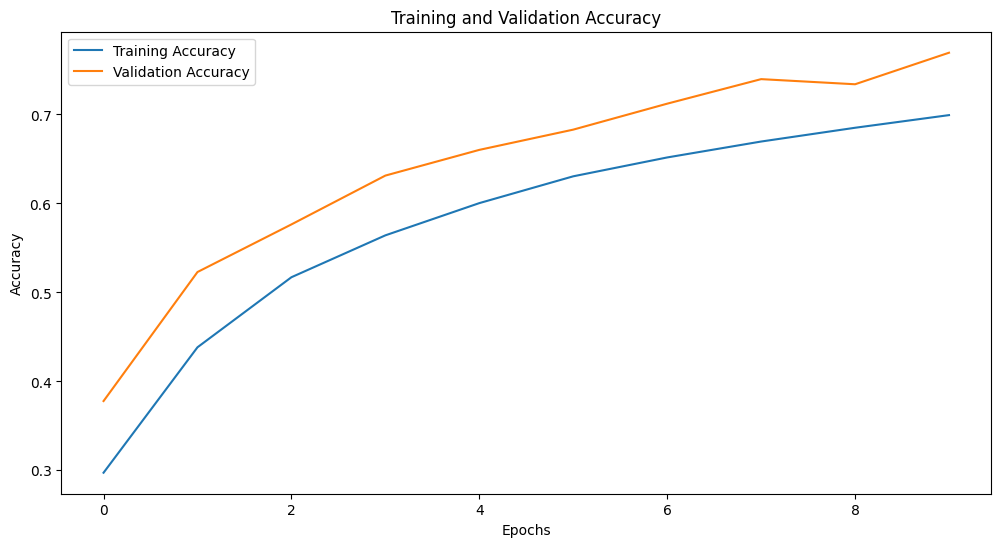

In [19]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Step 6: Build the 1D Convolutional Neural Network Model with Padding and Regularization
model = Sequential()

# Add 1D convolutional layer with ReLU activation and padding to prevent shrinking
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(X_train.shape[1], 1)))

# Add second convolutional layer with ReLU activation and padding
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))

# Add third convolutional layer with ReLU activation and padding
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))

# Add fourth convolutional layer with ReLU activation and padding
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

# Add fifth convolutional layer with ReLU activation and padding
model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

# Add Dropout after each fully connected layer to reduce overfitting
model.add(Dropout(0.5))

# Flatten the output of the convolutional layers to feed into fully connected layers
model.add(Flatten())

# Fully connected layer with ReLU activation
model.add(Dense(128, activation='relu'))

# Add Dropout after the fully connected layer to further reduce overfitting
model.add(Dropout(0.5))

# Output layer with softmax activation
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))  # Change this to entmax if needed

# Compile the model with Adam optimizer and sparse categorical crossentropy loss
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 7: Set up EarlyStopping to stop training if the validation loss doesn't improve for 3 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Step 8: Use ReduceLROnPlateau to reduce the learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Step 9: Train the model with validation data, and use EarlyStopping and ReduceLROnPlateau as callbacks
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop, reduce_lr])

# Step 10: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Step 11: Visualize Training and Validation Accuracy and Loss
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

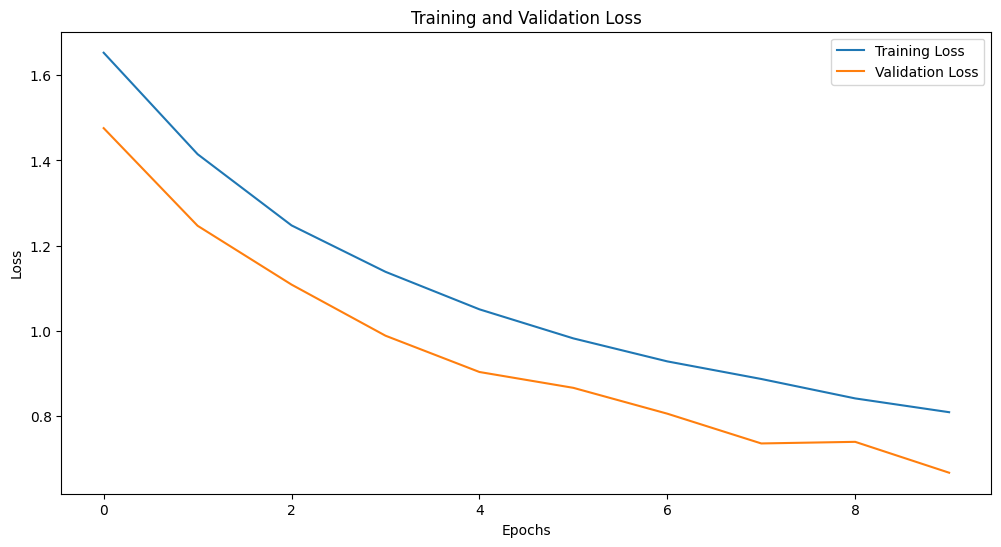

In [20]:
# Loss Plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.2481 - loss: 1.7310 - val_accuracy: 0.3664 - val_loss: 1.5244 - learning_rate: 0.0010
Epoch 2/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.3951 - loss: 1.4959 - val_accuracy: 0.4881 - val_loss: 1.3168 - learning_rate: 0.0010
Epoch 3/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.4810 - loss: 1.3312 - val_accuracy: 0.5638 - val_loss: 1.1505 - learning_rate: 0.0010
Epoch 4/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5396 - loss: 1.2038 - val_accuracy: 0.6044 - val_loss: 1.0457 - learning_rate: 0.0010
Epoch 5/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5797 - loss: 1.1113 - val_accuracy: 0.6496 - val_loss: 0.9663 - learning_rate: 0.0010
Epoch 6/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.6043 - loss: 1.0548 - val_accuracy: 0.6700 - val_loss: 0.8959 - learning_rate: 0.0010
Epoch 7/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6

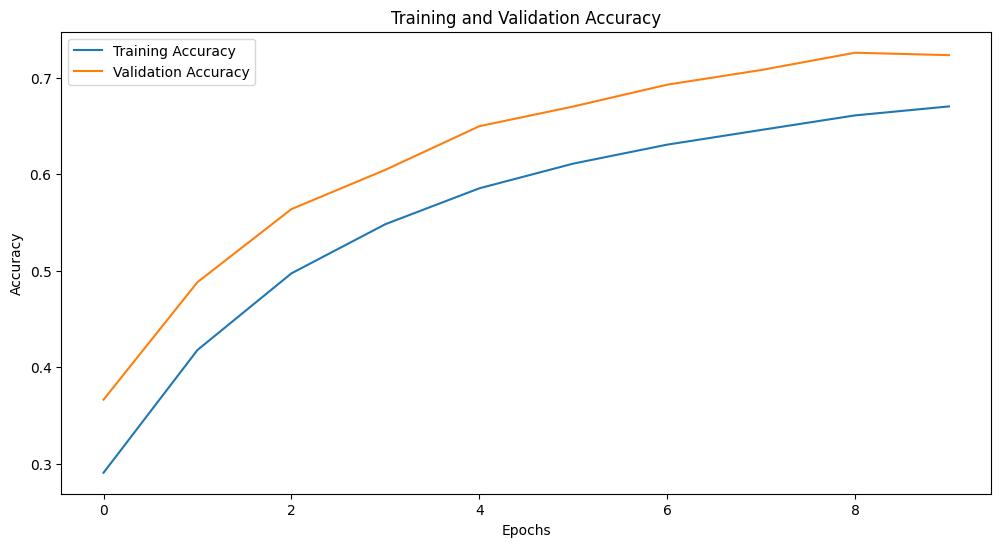

In [21]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Step 6: Build the 1D Convolutional Neural Network Model with Padding and Regularization
model = Sequential()

# Add 1D convolutional layer with ReLU activation and padding to prevent shrinking
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(X_train.shape[1], 1)))

# Add second convolutional layer with ReLU activation and padding
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

# Add third convolutional layer with ReLU activation and padding
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

# Add fourth convolutional layer with ReLU activation and padding
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

# Add Dropout after each fully connected layer to reduce overfitting
model.add(Dropout(0.5))

# Flatten the output of the convolutional layers to feed into fully connected layers
model.add(Flatten())

# Fully connected layer with ReLU activation
model.add(Dense(128, activation='relu'))

# Add Dropout after the fully connected layer to further reduce overfitting
model.add(Dropout(0.5))

# Output layer with softmax activation
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))  # Change this to entmax if needed

# Compile the model with Adam optimizer and sparse categorical crossentropy loss
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 7: Set up EarlyStopping to stop training if the validation loss doesn't improve for 3 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Step 8: Use ReduceLROnPlateau to reduce the learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Step 9: Train the model with validation data, and use EarlyStopping and ReduceLROnPlateau as callbacks
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop, reduce_lr])

# Step 10: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Step 11: Visualize Training and Validation Accuracy and Loss
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **4) LSTM**

       eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                         0          353733   
1  1628180742           1                         6          353733   
2  1628180742           2                         8          353733   
3  1628180742           3                        18          353733   
4  1628180742           4                        24          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                                 0   127492639   
1                   1                                 6  3887563113   
2                   2                                 8  1142670488   
3                   3                                18  2718991173   
4                   4                                24  3080632009   

   patient_id expert_consensus  seizure_vote  ...  RL_min  RL_max  LP_median  \
0       42516          Seizure             3  ...    0.02   73.17 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2670/2670 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 2/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 3/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 4/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
668/668 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: nan
Test Accuracy: 0.00


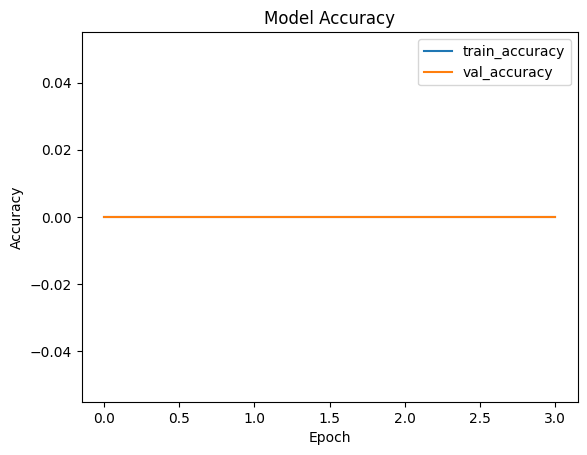

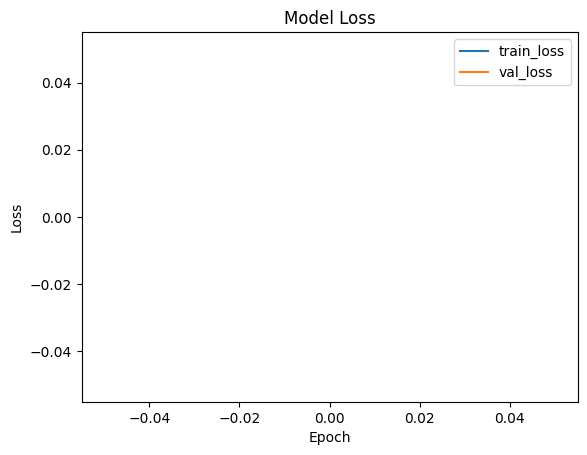

In [22]:
# 1. Import Libraries
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import auth
from google.auth import default
import gspread

# Authenticate and initialize gspread client
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Open the Google Sheet using the sheet ID (this is from your link)
sheet_id = "1ynXr2X-uyTEGlbhKHcq6rxJ0y8y25aORnBcDoj-_4HY"
worksheet = gc.open_by_key(sheet_id).sheet1  # Open the first sheet

# Get all data in the sheet as a list of dictionaries
data = worksheet.get_all_records()

# Convert to DataFrame
df = pd.DataFrame(data)

# Inspect the data
print(df.head())  # Corrected to 'df' instead of 'data'

# 3. Handle Missing Values
# Check for missing values in the DataFrame
print(df.isnull().sum())

# Fill missing values in numeric columns with the median
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Fill missing values in non-numeric columns with the most frequent value (mode)
non_numeric_cols = df.select_dtypes(exclude=['float64', 'int64']).columns
for col in non_numeric_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# 4. Feature Selection and Engineering
# Separate features and target variable (expert_consensus)
# Ensure the target variable is numeric, convert if necessary
df['expert_consensus'] = df['expert_consensus'].map({'Seizure': 1, 'Non-Seizure': 0})  # Example: mapping categories to numeric values

target = df['expert_consensus']
features = df[['LL_median', 'LL_std', 'LL_min', 'LL_max',
               'RL_median', 'RL_std', 'RL_min', 'RL_max',
               'LP_median', 'LP_std', 'LP_min', 'LP_max',
               'RP_median', 'RP_std', 'RP_min', 'RP_max']]

# 5. Normalize the Features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 6. Reshaping the Data for LSTM
# Reshaping data to fit LSTM input format [samples, time_steps, features]
X = scaled_features.reshape((scaled_features.shape[0], 1, scaled_features.shape[1]))

# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

# 8. Build the LSTM Model
model = Sequential()

# Add LSTM layer
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))

# Add output layer for classification (assuming binary classification)
model.add(Dense(1, activation='sigmoid'))  # Use softmax if it's multi-class

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 9. Add EarlyStopping Callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 10. Train the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

# 11. Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# 12. Optionally, Plot the Training History
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

False False
False False
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2670/2670 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.1761 - loss: -0.8313 - val_accuracy: 0.1736 - val_loss: -10.5330
Epoch 2/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.1760 - loss: -17.4970 - val_accuracy: 0.1736 - val_loss: -44.4803
Epoch 3/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1752 - loss: -56.9873 - val_accuracy: 0.1736 - val_loss: -98.6498
Epoch 4/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.1752 - loss: -116.8691 - val_accuracy: 0.1736 - val_loss: -169.9688
Epoch 5/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.1767 - loss: -194.0430 - val_accuracy: 0.1736 - val_loss: -256.8392
Epoch 6/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.1768 - loss: -283.5769 - val_accuracy: 0.1736 - val_loss: -359.0840
Epoch 7/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1776 - loss: -387.3073 - val_accuracy: 0.1736 - val_loss: -476.5458
Epoch 8/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accurac

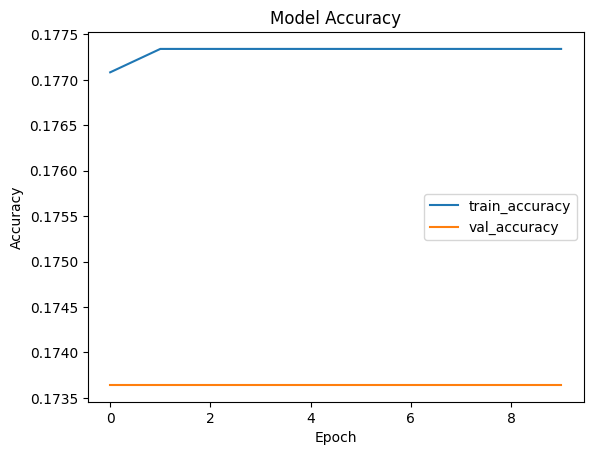

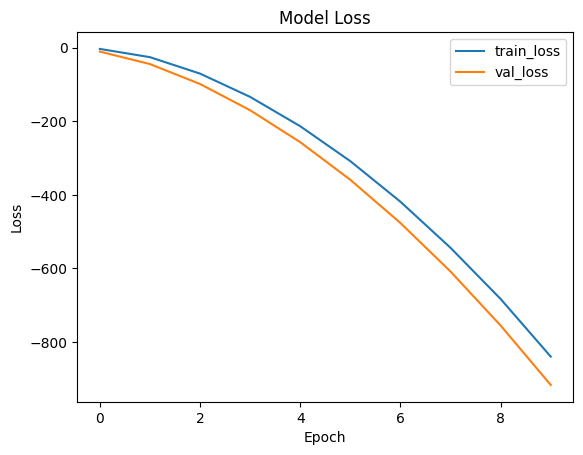

In [23]:
# 1. Import Libraries
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

from google.colab import auth
from google.auth import default
import gspread

# Authenticate and initialize gspread client
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Open the Google Sheet using the sheet ID (this is from your link)
sheet_id = "1ynXr2X-uyTEGlbhKHcq6rxJ0y8y25aORnBcDoj-_4HY"
worksheet = gc.open_by_key(sheet_id).sheet1  # Open the first sheet

# Get all data in the sheet as a list of dictionaries
data = worksheet.get_all_records()

# Convert to DataFrame
df = pd.DataFrame(data)

# Handle Missing Values
non_numeric_cols = df.select_dtypes(exclude=['float64', 'int64']).columns
for col in non_numeric_cols:
    df[col] = df[col].fillna(df[col].mode()[0])  # Fill missing values in non-numeric columns with mode

# Convert the target variable to numeric using LabelEncoder
label_encoder = LabelEncoder()
df['expert_consensus'] = label_encoder.fit_transform(df['expert_consensus'])

# Feature selection and normalization
target = df['expert_consensus']
features = df[['LL_median', 'LL_std', 'LL_min', 'LL_max',
               'RL_median', 'RL_std', 'RL_min', 'RL_max',
               'LP_median', 'LP_std', 'LP_min', 'LP_max',
               'RP_median', 'RP_std', 'RP_min', 'RP_max']]

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Check for NaN or infinite values in the scaled features and target
print(np.any(np.isnan(scaled_features)), np.any(np.isinf(scaled_features)))
print(np.any(np.isnan(target)), np.any(np.isinf(target)))

# Reshaping the data for LSTM (as LSTM expects 3D input: [samples, time_steps, features])
X = scaled_features.reshape((scaled_features.shape[0], 1, scaled_features.shape[1]))  # Reshape to 3D format

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

# Build the LSTM Model
model = Sequential()

# Add LSTM layer
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))

# Add Dropout layer for stability
model.add(Dropout(0.2))

# Add output layer
model.add(Dense(1, activation='sigmoid'))  # For binary classification (0 or 1)

# Compile the model with a smaller learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Optionally, plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
